# Used cars

In [3]:
import pandas as pd
used_cars = pd.read_csv("../data/external/used_cars.csv")

In [4]:
used_cars.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [5]:
used_cars.shape

(4009, 12)

In [6]:
train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")
print(train.shape, test.shape)

(188533, 13) (125690, 12)


In [9]:
test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [7]:
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [8]:
train.dtypes

id               int64
brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object

In [ ]:
train.milage = train.milage.astype(int)


## brand

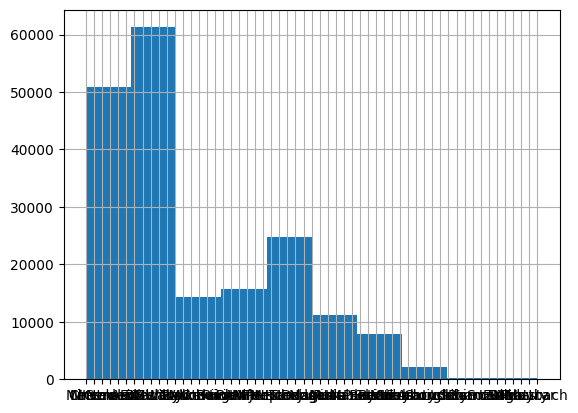

In [23]:
train.brand.hist()
tr_brand = train.brand.value_counts(dropna=False)/len(train)

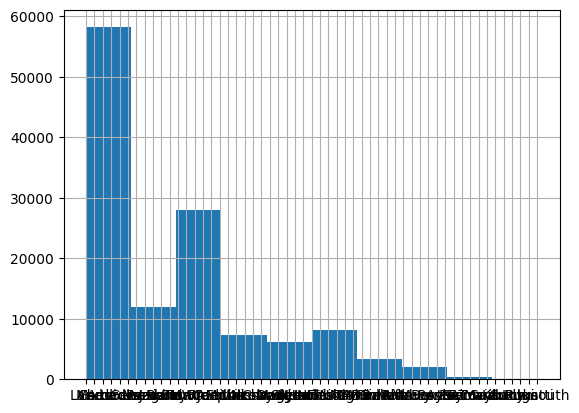

In [24]:
test.brand.hist()
te_brand = test.brand.value_counts(dropna=False)/len(test)

In [31]:
uc_brand.sort_values(ascending=False)

brand
Ford             0.096283
BMW              0.093540
Mercedes-Benz    0.078573
Chevrolet        0.072836
Porsche          0.050137
Audi             0.049888
Toyota           0.049638
Lexus            0.040659
Jeep             0.035670
Land             0.032427
Nissan           0.028935
Cadillac         0.026690
GMC              0.022699
RAM              0.022699
Dodge            0.022449
Tesla            0.021701
Kia              0.018957
Hyundai          0.017960
Mazda            0.015964
Acura            0.015964
Subaru           0.015964
Honda            0.015715
Volkswagen       0.014717
INFINITI         0.014717
Lincoln          0.012971
Jaguar           0.011724
Volvo            0.009479
Maserati         0.008481
MINI             0.008231
Bentley          0.008231
Buick            0.007483
Chrysler         0.006984
Lamborghini      0.006485
Mitsubishi       0.004989
Genesis          0.004989
Alfa             0.004739
Rivian           0.004240
Hummer           0.003991
Pontia

In [27]:
tr_brand.sort_values(ascending=False)

brand
Ford             0.122461
Mercedes-Benz    0.101690
BMW              0.090318
Chevrolet        0.086643
Audi             0.057746
Porsche          0.056287
Land             0.050522
Toyota           0.046941
Lexus            0.045843
Jeep             0.034339
Cadillac         0.024791
RAM              0.022537
Nissan           0.020845
Tesla            0.019827
INFINITI         0.017376
GMC              0.017053
Dodge            0.016618
Mazda            0.014422
Kia              0.013244
Lincoln          0.012852
Subaru           0.012629
Acura            0.012104
Honda            0.011144
Hyundai          0.010847
Volkswagen       0.009362
Jaguar           0.006996
Bentley          0.006126
MINI             0.005644
Genesis          0.005140
Buick            0.004986
Maserati         0.004981
Lamborghini      0.004291
Chrysler         0.003856
Volvo            0.003835
Alfa             0.003617
Rivian           0.003129
Rolls-Royce      0.002976
Mitsubishi       0.002923
Pontia

In [28]:
te_brand.sort_values(ascending=False)

brand
Ford             0.121450
Mercedes-Benz    0.102435
BMW              0.089792
Chevrolet        0.085114
Audi             0.057992
Porsche          0.056910
Land             0.050505
Toyota           0.048405
Lexus            0.045580
Jeep             0.035102
Cadillac         0.024338
RAM              0.021903
Nissan           0.021275
Tesla            0.018991
INFINITI         0.016891
GMC              0.016660
Dodge            0.016477
Mazda            0.014082
Kia              0.013923
Lincoln          0.012674
Subaru           0.012658
Acura            0.012467
Honda            0.011425
Hyundai          0.010407
Volkswagen       0.009722
Jaguar           0.007431
Bentley          0.006277
MINI             0.005545
Buick            0.005179
Genesis          0.005116
Maserati         0.004925
Volvo            0.004583
Lamborghini      0.004352
Chrysler         0.004089
Alfa             0.003715
Rivian           0.003103
Rolls-Royce      0.003047
Mitsubishi       0.002920
Hummer

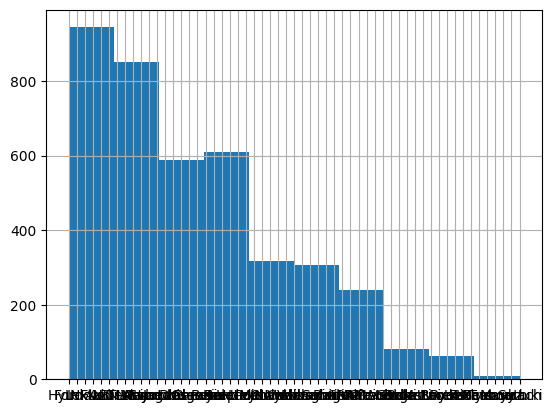

In [29]:
used_cars.brand.hist()
uc_brand = used_cars.brand.value_counts(dropna=False)/len(used_cars)

In [30]:
uc_brand.sort_values(ascending=False)

brand
Ford             0.096283
BMW              0.093540
Mercedes-Benz    0.078573
Chevrolet        0.072836
Porsche          0.050137
Audi             0.049888
Toyota           0.049638
Lexus            0.040659
Jeep             0.035670
Land             0.032427
Nissan           0.028935
Cadillac         0.026690
GMC              0.022699
RAM              0.022699
Dodge            0.022449
Tesla            0.021701
Kia              0.018957
Hyundai          0.017960
Mazda            0.015964
Acura            0.015964
Subaru           0.015964
Honda            0.015715
Volkswagen       0.014717
INFINITI         0.014717
Lincoln          0.012971
Jaguar           0.011724
Volvo            0.009479
Maserati         0.008481
MINI             0.008231
Bentley          0.008231
Buick            0.007483
Chrysler         0.006984
Lamborghini      0.006485
Mitsubishi       0.004989
Genesis          0.004989
Alfa             0.004739
Rivian           0.004240
Hummer           0.003991
Pontia

## model_year

In [37]:
train["model_year_cut"] = pd.cut(train["model_year"], bins=10)
test["model_year_cut"] = pd.cut(test["model_year"], bins=10)
used_cars["model_year_cut"] = pd.cut(used_cars["model_year"], bins=10)

In [38]:
train.model_year_cut.value_counts()/len(train)

model_year_cut
(2014.0, 2019.0]     0.369707
(2019.0, 2024.0]     0.311489
(2009.0, 2014.0]     0.168703
(2004.0, 2009.0]     0.099139
(1999.0, 2004.0]     0.041637
(1994.0, 1999.0]     0.007956
(1989.0, 1994.0]     0.001305
(1973.95, 1979.0]    0.000064
(1979.0, 1984.0]     0.000000
(1984.0, 1989.0]     0.000000
Name: count, dtype: float64

In [39]:
test.model_year_cut.value_counts()/len(test)

model_year_cut
(2014.0, 2019.0]     0.367102
(2019.0, 2024.0]     0.310804
(2009.0, 2014.0]     0.170801
(2004.0, 2009.0]     0.100390
(1999.0, 2004.0]     0.041085
(1994.0, 1999.0]     0.008338
(1989.0, 1994.0]     0.001416
(1973.95, 1979.0]    0.000048
(1979.0, 1984.0]     0.000008
(1984.0, 1989.0]     0.000008
Name: count, dtype: float64

In [40]:
used_cars.model_year_cut.value_counts()/len(used_cars)

model_year_cut
(2014.0, 2019.0]     0.340983
(2019.0, 2024.0]     0.313794
(2009.0, 2014.0]     0.175605
(2004.0, 2009.0]     0.105014
(1999.0, 2004.0]     0.047892
(1994.0, 1999.0]     0.012222
(1989.0, 1994.0]     0.004240
(1973.95, 1979.0]    0.000249
(1979.0, 1984.0]     0.000000
(1984.0, 1989.0]     0.000000
Name: count, dtype: float64

## milage

<Axes: >

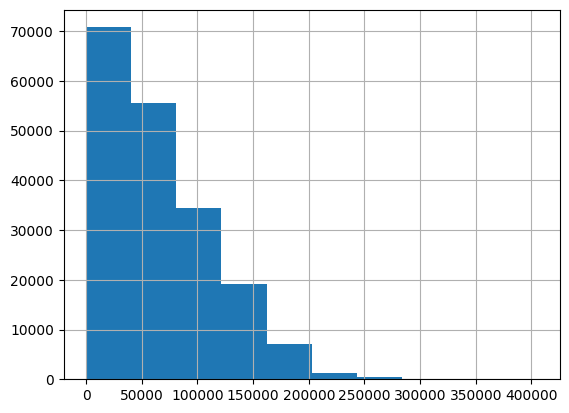

In [42]:
train.milage.hist()

<Axes: >

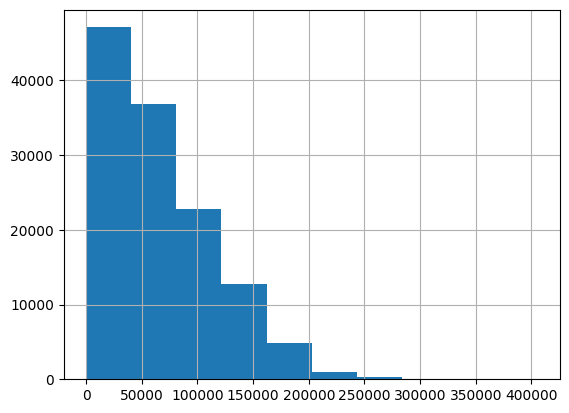

In [43]:
test.milage.hist()

<Axes: >

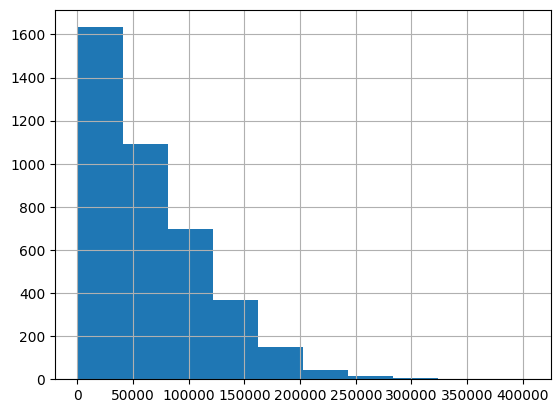

In [71]:
used_cars["milage_i"]= used_cars["milage"].str.replace("mi.","").replace(" ","").str.replace(",","").astype(int, errors="ignore")
used_cars["milage_i"].hist()

In [73]:
train["milage_cut"] = pd.cut(train["milage"], bins=10)
test["milage_cut"] = pd.cut(test["milage"], bins=10)
used_cars["milage_cut"] = pd.cut(used_cars["milage_i"], bins=10)

In [76]:
train["milage_cut"].value_counts() / len(train)

milage_cut
(-304.9, 40590.0]       0.375505
(40590.0, 81080.0]      0.294399
(81080.0, 121570.0]     0.182260
(121570.0, 162060.0]    0.101293
(162060.0, 202550.0]    0.037177
(202550.0, 243040.0]    0.006391
(243040.0, 283530.0]    0.002530
(283530.0, 324020.0]    0.000170
(324020.0, 364510.0]    0.000143
(364510.0, 405000.0]    0.000133
Name: count, dtype: float64

In [77]:
test.milage_cut.value_counts() / len(test)

milage_cut
(-304.9, 40590.0]       0.374533
(40590.0, 81080.0]      0.293341
(81080.0, 121570.0]     0.181470
(121570.0, 162060.0]    0.101766
(162060.0, 202550.0]    0.038118
(202550.0, 243040.0]    0.007574
(243040.0, 283530.0]    0.002681
(283530.0, 324020.0]    0.000247
(364510.0, 405000.0]    0.000159
(324020.0, 364510.0]    0.000111
Name: count, dtype: float64

In [78]:
used_cars.milage_cut.value_counts()/len(used_cars)

milage_cut
(-304.9, 40590.0]       0.407333
(40590.0, 81080.0]      0.272637
(81080.0, 121570.0]     0.174108
(121570.0, 162060.0]    0.092292
(162060.0, 202550.0]    0.037416
(202550.0, 243040.0]    0.010726
(243040.0, 283530.0]    0.003742
(283530.0, 324020.0]    0.000998
(364510.0, 405000.0]    0.000499
(324020.0, 364510.0]    0.000249
Name: count, dtype: float64

## clean_title

In [9]:
train.clean_title.value_counts(dropna=False), train.clean_title.value_counts(dropna=False)/len(train)

(clean_title
 Yes    167114
 NaN     21419
 Name: count, dtype: int64,
 clean_title
 Yes    0.886391
 NaN    0.113609
 Name: count, dtype: float64)

In [10]:
test.clean_title.value_counts(dropna=False), test.clean_title.value_counts(dropna=False)/len(test)

(clean_title
 Yes    111451
 NaN     14239
 Name: count, dtype: int64,
 clean_title
 Yes    0.886713
 NaN    0.113287
 Name: count, dtype: float64)

In [26]:
used_cars.clean_title.value_counts(dropna=False), used_cars.clean_title.value_counts(dropna=False)/len(used_cars)

(clean_title
 Yes    3413
 NaN     596
 Name: count, dtype: int64,
 clean_title
 Yes    0.851334
 NaN    0.148666
 Name: count, dtype: float64)

## accident

In [27]:
train.accident.value_counts(dropna=False), train.accident.value_counts(dropna=False)/len(train)

(accident
 None reported                             144514
 At least 1 accident or damage reported     41567
 NaN                                         2452
 Name: count, dtype: int64,
 accident
 None reported                             0.766518
 At least 1 accident or damage reported    0.220476
 NaN                                       0.013006
 Name: count, dtype: float64)

In [28]:
test.accident.value_counts(dropna=False), test.accident.value_counts(dropna=False)/len(test)

(accident
 None reported                             96263
 At least 1 accident or damage reported    27795
 NaN                                        1632
 Name: count, dtype: int64,
 accident
 None reported                             0.765876
 At least 1 accident or damage reported    0.221139
 NaN                                       0.012984
 Name: count, dtype: float64)

In [29]:
used_cars.accident.value_counts(dropna=False), used_cars.accident.value_counts(dropna=False)/len(used_cars)

(accident
 None reported                             2910
 At least 1 accident or damage reported     986
 NaN                                        113
 Name: count, dtype: int64,
 accident
 None reported                             0.725867
 At least 1 accident or damage reported    0.245947
 NaN                                       0.028187
 Name: count, dtype: float64)

In [16]:
for col in train.columns.to_list():
    if col in ["id","engine","price"]:
        continue
    print("***"*10, col ,"***"*10)
    print(train[col].value_counts(dropna=False), train[col].value_counts(dropna=False) / len(train))
    print(test[col].value_counts(dropna=False), test[col].value_counts(dropna=False) / len(test))
    print(used_cars[col].value_counts(dropna=False), used_cars[col].value_counts(dropna=False)/len(used_cars))

****************************** brand ******************************
brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Volkswagen        1765
Jaguar            1319
Bentley           1155
MINI              1064
Genesis            969
Buick              940
Maserati           939
Lamborghini        809
Chrysler           727
Volvo              723
Alfa               682
Rivian             590
Rolls-Royce        561
Mitsubishi         551
Pontiac            538
Hummer             520
Ferrar

<Axes: >

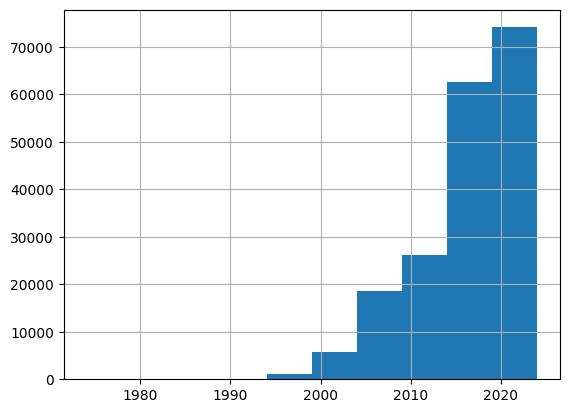

In [6]:
train.model_year.hist()

<Axes: >

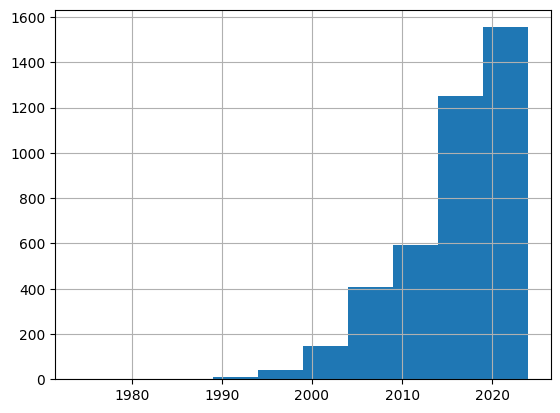

In [7]:
used_cars.model_year.hist()

<Axes: >

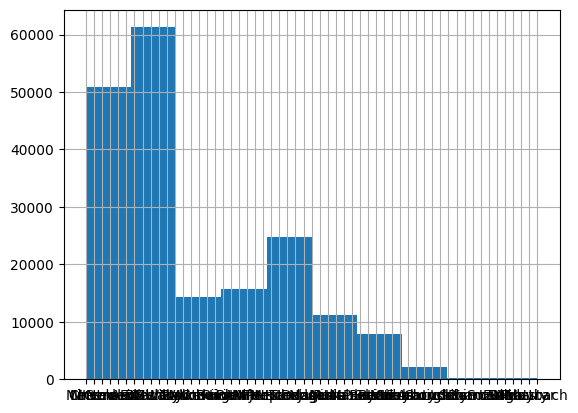

In [8]:
train.brand.hist()

<Axes: >

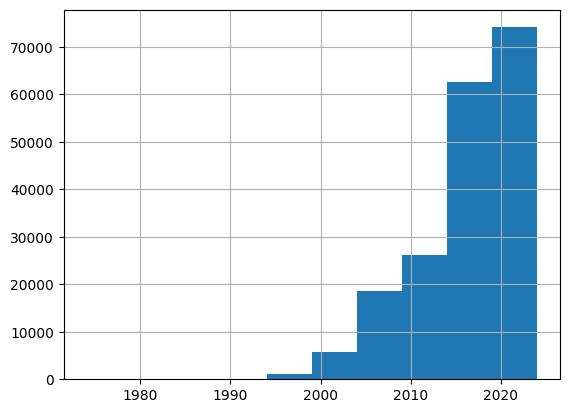

In [10]:
train.model_year.hist()

<Axes: >

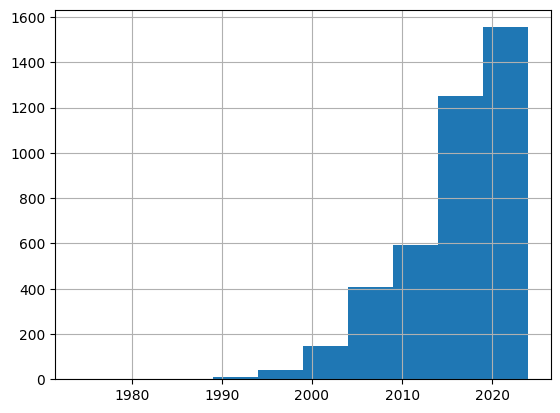

In [11]:
used_cars.model_year.hist()

## Price

In [11]:
used_cars.price.value_counts()

price
15,000    39
12,000    29
30,000    28
16,000    25
29,000    25
          ..
43,666     1
70,250     1
80,140     1
31,750     1
90,998     1
Name: count, Length: 1569, dtype: int64

In [10]:
used_cars["price"]= used_cars["price"].str.replace("$","").astype(int, errors="ignore")

In [9]:
train.price.value_counts()

price
15000     1920
12000     1459
30000     1280
29000     1228
8500      1204
          ... 
239991      22
269991      22
259991      21
107998      20
45998       19
Name: count, Length: 1569, dtype: int64

# CHECK H5 file

In [22]:
import h5py
def load_hdf5(path):
    """Load data from a HDF5 file.

    Args:
        path (str): A path to the HDF5 format file containing data.
        dense (boolean): An optional variable indicating if the return matrix
                         should be dense.  By default, it is false.

    Returns:
        Data matrix X and target vector y
    """

    with h5py.File(path, "r") as f:
        is_sparse = f["issparse"][...]
        if is_sparse:
            shape = tuple(f["shape"][...])
            data = f["data"][...]
            indices = f["indices"][...]
            indptr = f["indptr"][...]
            X = sparse.csr_matrix((data, indices, indptr), shape=shape)
        else:
            X = f["data"][...]

        y = f["target"][...]

    return X, y

In [26]:
X, y = load_hdf5("/home/kenny/program/kaggle/playground-series-s4e9/build/feature/j6.tst.h5")

In [27]:
X

array([[1.1000e+01, 3.3500e+02, 2.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        8.0000e+00],
       [1.1000e+01, 1.8000e+01, 4.0000e+00, ..., 1.0858e+04, 1.0000e+00,
        3.0000e+00],
       [7.0000e+00, 7.7000e+01, 2.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        1.0000e+00],
       ...,
       [6.0000e+00, 0.0000e+00, 2.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        1.1000e+01],
       [6.0000e+00, 1.2540e+03, 2.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        1.1000e+01],
       [3.0000e+00, 8.9000e+01, 2.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        5.0000e+00]])

In [25]:
X.shape

(125690, 30)

In [ ]:
X, y = load_hdf5("/home/kenny/program/kaggle/playground-series-s4e9/build/feature/j4c.tst.h5")

In [5]:
for i in range(X.shape[1]):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [5]:
X.shape

(125690, 11)

In [13]:
import torch
import torch.nn as nn


class TabularModel(nn.Module):
    def __init__(self, num_num_features, cat_embed_sizes):
        super(TabularModel, self).__init__()

        # Embedding layers for categorical features
        self.embeddings = nn.ModuleList([nn.Embedding(cat_size, emb_size) for cat_size, emb_size in cat_embed_sizes])
        
        # Input size will be the sum of the embedding sizes for categorical features + numerical features
        total_input_size = sum([emb_size for _, emb_size in cat_embed_sizes]) + num_num_features
        
        # Fully connected layers
        self.fc1 = nn.Linear(total_input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, 1)  # Output for regression
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, cat_data, num_data):
        # Embedding categorical features and flattening the result
        embedded_cat = [emb(cat_data[:, i]) for i, emb in enumerate(self.embeddings)]
        embedded_cat = torch.cat([x.view(x.size(0), -1) for x in embedded_cat], dim=1)
        
        # Concatenate embedded categorical data with numerical data
        x = torch.cat([embedded_cat, num_data], dim=1)
        
        # Pass through fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        output = self.fc_out(x)
        
        return output


In [15]:
import numpy as np
CAT_EMB = []
CAT_SIZE = []
for i in range(X.shape[1]):    
    print(i)
    CAT_SIZE.append(len(set(X[:,i]))+1)
    CAT_EMB.append(int(np.ceil(np.sqrt(X[:,i].max())))) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


ValueError: cannot convert float NaN to integer

In [20]:
X[:,17:18]

array([[ 98000.],
       [  9142.],
       [ 28121.],
       ...,
       [ 77634.],
       [112000.],
       [ 66840.]])

In [22]:
CAT_EMB

[8, 44, 3, 34, 8, 18, 13, 2, 1, 45, 637]

In [23]:
CAT_SIZE

[56, 1892, 9, 1118, 53, 318, 157, 4, 3, 37, 5701]

In [24]:
X[:,9].max()

2024

In [25]:
X[:,9]

array([2015, 2020, 2022, ..., 2012, 2012, 2018])

In [26]:
cat_embed_sizes = zip(CAT_SIZE, CAT_EMB)
embeddings = nn.ModuleList([nn.Embedding(cat_size, emb_size) for cat_size, emb_size in cat_embed_sizes])

# Input size will be the sum of the embedding sizes for categorical features + numerical features
total_input_size = sum([emb_size for _, emb_size in cat_embed_sizes]) + 1

# Fully connected layers
fc1 = nn.Linear(total_input_size, 128)
fc2 = nn.Linear(128, 64)
fc_out = nn.Linear(64, 1)  # Output for regression

In [29]:
cat_embed_sizes = zip(CAT_SIZE, CAT_EMB)
for cat_size, emb_size in cat_embed_sizes:
    print(cat_size, emb_size)

56 8
1892 44
9 3
1118 34
53 8
318 18
157 13
4 2
3 1
37 45
5701 637


In [30]:
md = TabularModel(num_num_features=1, cat_embed_sizes=zip(CAT_SIZE, CAT_EMB))
md(torch.tensor(X[:,0:9]), torch.tensor(X[:,10]))

IndexError: index out of range in self

In [55]:
embeddings

ModuleList(
  (0): Embedding(56, 8)
  (1): Embedding(1892, 44)
  (2): Embedding(9, 3)
  (3): Embedding(1118, 34)
  (4): Embedding(53, 8)
  (5): Embedding(318, 18)
  (6): Embedding(157, 13)
  (7): Embedding(4, 2)
  (8): Embedding(3, 2)
  (9): Embedding(37, 6)
  (10): Embedding(5701, 76)
)

In [69]:
set(X[:,1]), 

({0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

In [ ]:
TARGET_COL = 'price'
ID_COL = 'id'
N_FOLD = 5
SEED = 42

trn = pd.read_csv("/home/kenny/program/kaggle/playground-series-s4e9/data/raw/train.csv", index_col=ID_COL)
tst = pd.read_csv("/home/kenny/program/kaggle/playground-series-s4e9/data/raw/test.csv", index_col=ID_COL)


y = trn[TARGET_COL].values
n_trn = trn.shape[0]


def ft_eng(df):       
    df['brand_model'] = df['brand'] + '_' + df['model']        
    # Extract horsepower from engine descriptions
    df['horsepower'] = df['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
    df['engine_v'] = df['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
    df['power_to_fuel_type'] = df['horsepower'].astype(str) + '_' + df['fuel_type']
    # Calculate age of vehicle
    current_year = pd.Timestamp('now').year
    df['vehicle_age'] = current_year - df['model_year']
    df['vehicle_age_x_horsepower'] = df["horsepower"] * df['model_year']
    df['vehicle_age_horsepower_mean'] = df[["horsepower",'model_year']].mean(axis=1)
    df['mileage_per_year'] = df['milage'] / (current_year - df['model_year'] + 1)
    df['color_combo'] = df['ext_col'] + '_' + df['int_col']
    # Create fuel economy category based on fuel type
    fuel_categories = {
        'Gasoline': 'Fossil',
        'Diesel': 'Fossil',
        'Hybrid': 'Hybrid',
        'Electric': 'Electric',
        'E85 Flex Fuel': 'Flex'
    }
    df['fuel_category'] = df['fuel_type'].map(fuel_categories)
    # Convert accident history to binary
    df['has_accident'] = (df['accident'] != 'None reported').astype(int)
    # Clean title binary conversion
    df['is_title_clean'] = (df['clean_title'] == 'Yes').astype(int)
    df['accident_title_status'] = df['accident'].astype(str) + '_' + df['clean_title'].astype(str)
    # df['engine_transmission'] = df['engine'].str.extract(r'(\d+\.?\d*)L') + '_' + df['transmission']
    df['model_year_fuel_type'] = df['model_year'].astype(str) + '_' + df['fuel_type']
    # Simplify transmission types
    transmission_categories = {
        'Automatic': 'Automatic',
        'Manual': 'Manual',
        'A/T': 'Automatic',
        'M/T': 'Manual'
    }
    df['transmission_type'] = df['transmission'].replace(transmission_categories).fillna('Other')
    df['milage_impact1'] = df['milage'].apply(lambda x: 1 if x < 20000 else 0)
    
    df['milage_impact2'] = df['milage'].apply(lambda x: 20000 - x if x < 20000 else 0)
    df['model_year_impact1'] = df['model_year'].apply(lambda x: 1 if (x >= 2001 & x <= 2023) else 0)
    df['model_year_impact2'] = df['model_year'].apply(lambda x: 2023 - x if (x >= 2001 & x <= 2023) else 0)
    
    for col in ['has_accident', 'fuel_category', 'milage_impact1', 'milage_impact2', 'model_year_impact1', 'model_year_impact2', 'milage_impact1', 'model_year']:
        df[col] = df[col].astype("category")
    # num_cols = [x for x in trn.columns if trn[x].dtype != 'object' and x != TARGET_COL]
    # print(num_cols)
    # df["target_transf"] = df[TARGET_COL] - df[num_cols].mean(axis=1) * 0.1
    # df["sum"] = df[num_cols].sum(axis=1)
    # df["sum_std"] = df.groupby("sum")[TARGET_COL].std()

    return df

trn = ft_eng(trn)
tst = ft_eng(tst)

trn.drop(TARGET_COL, axis=1, inplace=True)

cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
num_cols = [x for x in trn.columns if trn[x].dtype != 'object']